In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

In [24]:
model_type = 'CNN2'
invar = 'ALL'
channels = 3
resolution = '2deg'
indexregion = 'NAT'
percent_train = 1

In [3]:
def calc_layerdims(nx,ny,filtersizes,filterstrides,poolsizes,poolstrides,nchannels):
    """
    For a series of N convolutional layers, calculate the size of the first fully-connected 
    layer
    
    Inputs:
        nx:           x dimensions of input
        ny:           y dimensions of input
        filtersize:   [ARRAY,length N] sizes of the filter in each layer [(x1,y1),[x2,y2]]
        poolsize:     [ARRAY,length N] sizes of the maxpooling kernel in each layer
        nchannels:    [ARRAY,] number of out_channels in each layer
    output:
        flattensize:  flattened dimensions of layer for input into FC layer
    
    """
    
    # # ## Debug entry
    # # 2 layer CNN settings 
    # nchannels     = [32,64]
    # filtersizes   = [[2,3],[3,3]]
    # filterstrides = [[1,1],[1,1]]
    # poolsizes     = [[2,3],[2,3]]
    # poolstrides   = [[2,3],[2,3]]
    # nx = 33
    # ny = 41
    # # # ----
    
    
    N = len(filtersizes)
    xsizes = [nx]
    ysizes = [ny]
    fcsizes  = []
    
    for i in range(N):
        
        xsizes.append(np.floor((xsizes[i]-filtersizes[i][0])/filterstrides[i][0])+1)
        ysizes.append(np.floor((ysizes[i]-filtersizes[i][1])/filterstrides[i][1])+1)
        
        
        xsizes[i+1] = np.floor((xsizes[i+1] - poolsizes[i][0])/poolstrides[i][0]+1)
        ysizes[i+1] = np.floor((ysizes[i+1] - poolsizes[i][1])/poolstrides[i][1]+1)
        
        fcsizes.append(np.floor(xsizes[i+1]*ysizes[i+1]*nchannels[i]))
    
    return int(fcsizes[-1])

In [4]:
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,klat[:,None],klon[None,:]]
    
    # Take mean over region
    amv_index = np.nanmean(selvar,(1,2))
    
    return amv_index

In [5]:
sst = xr.open_dataset('../../CESM_data/HadISST_sst_NAtl_18700101_20181201_Regridded2deg.nc')
sss = xr.open_dataset('../../CESM_data/CGLORSv5_sss_NAtl_19800115_20160101_Regridded2deg.nc')
psl = xr.open_dataset('../../CESM_data/NOAA20CR_psl_NAtl_18510101_20141201_Regridded2deg.nc')

sst = (sst.groupby('time.month') - sst.groupby('time.month').mean('time')).groupby('time.year').mean('time')
sss = (sss.groupby('time.month') - sss.groupby('time.month').mean('time')).groupby('time.year').mean('time')
psl = (psl.groupby('time.month') - psl.groupby('time.month').mean('time')).groupby('time.year').mean('time')

In [6]:
sst_normed = ((sst - sst.mean())/sst.std())['sst'][1980-1870:-2018+2014,0:33,5:46].values.astype(np.float32)

sss_normed = ((sss - sss.mean())/sss.std())['sss'][:-2016+2014,0:33,5:46].values.astype(np.float32)

psl_normed = ((psl - psl.mean())/psl.std())['psl'][1980-1851:,0:33,5:46].values.astype(np.float32)


In [8]:
# Load lat/lon
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))
tstep,nlat,nlon = sst_normed.shape

In [31]:

nchannels     = [32,64]
filtersizes   = [[2,3],[3,3]]
filterstrides = [[1,1],[1,1]]
poolsizes     = [[2,3],[2,3]]
poolstrides   = [[2,3],[2,3]]
firstlineardim = calc_layerdims(nlat,nlon,filtersizes,filterstrides,poolsizes,poolstrides,nchannels)
layers  = [
            nn.Conv2d(in_channels=channels, out_channels=nchannels[0], kernel_size=filtersizes[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=poolsizes[0]),

            nn.Conv2d(in_channels=nchannels[0], out_channels=nchannels[1], kernel_size=filtersizes[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=poolsizes[1]),            

            nn.Flatten(),
            nn.Linear(in_features=firstlineardim,out_features=64),
            nn.ReLU(),

            #nn.Dropout(p=0.5),
            nn.Linear(in_features=64,out_features=1)
          ]
model = nn.Sequential(*layers)



In [46]:
path = '../../CESM_data/Models/'

leads = np.arange(0,25,1)
corrs = []
for lead in leads:
    y =  calc_AMV_index(indexregion,sst_normed[lead:,:,:],lat,lon) 
    y = y.reshape(y.shape[0],1)
    invars = [sst_normed,sss_normed,psl_normed]
    X = np.transpose(
                np.array(invars)[:,0:tstep-lead,:,:].reshape(channels,tstep-lead,nlat,nlon),
                (1,0,2,3))
    X[np.isnan(X)] = 0
    X_train = torch.from_numpy( X[0:int(np.floor(percent_train*(tstep-lead))),:,:,:] )
    X_val = torch.from_numpy( X[int(np.floor(percent_train*(tstep-lead))):,:,:,:] )

    y_train = torch.from_numpy( y[0:int(np.floor(percent_train*(tstep-lead))),:] )
    y_val = torch.from_numpy( y[int(np.floor(percent_train*(tstep-lead))):,:] )
    
    for fname in os.listdir(path):
        if 'lead'+str(lead)+'.pt' in fname and model_type in fname and invar in fname:

            model.load_state_dict(torch.load(path+fname))
            model.eval()
            y_pred = model(X_train)

            corrs.append( np.corrcoef(y_pred[:,0].detach().numpy(),y[:,0])[0,1] )


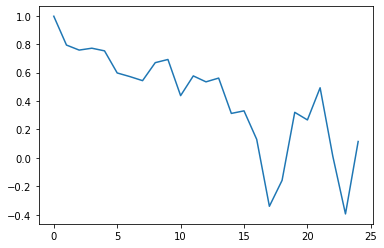

In [47]:
plt.plot(leads, corrs)